# Improving the Double DQN algorithm using prioritized experience replay 
> Notes on improving the Double DQN algorithm using prioritized experience replay.

- branch: 2020-04-14-prioritized-experience-replay
- badges: true
- image: images/prioritized-experience-replay.png
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, deep-q-networks]

I am continuing to work my way through the [Udacity](https://www.udacity.com/) [*Deep Reinforcement Learning Nanodegree*](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). In this blog post I discuss and implement an enhancement of the `ExperienceReplayBuffer` from [*Prioritized Experience Replay*](https://arxiv.org/abs/1511.05952) (Schaul et al 2016).

> Experience replay liberates online learning agents from processing transitions in the exact order
they are experienced. Prioritized replay further liberates agents from considering transitions with
the same frequency that they are experienced.

> In particular, we propose to more frequently replay transitions with high expected learning progress,
as measured by the magnitude of their temporal-difference (TD) error. This prioritization can lead
to a loss of diversity, which we alleviate with stochastic prioritization, and introduce bias, which
we correct with importance sampling.

## Prioritized Experience Replay

Using an experience replay buffer naturally leads to two issues that need to be addressed. 

1. Which experiences should the agent store in the replay buffer?
2. Which experiences to replay from the buffer in order to learn efficiently?

Schaul et al 2016 take the contents of the replay buffer more or less as given and focus solely on 
answering the second question. That is, the paper focuses on developing a procedure for making the 
most effective use of the experience replay buffer for learning.

Before discussing the procedure to sample from prioritized experiences, I need to discuss how what 
information a reinforcement learning (RL) agent has available to prioritize its experiences for 
replay.

### Prioritization using the temporal-difference (TD) error term

You can't prioritize experiences for learning unless you can measure the importance of each 
experience in the learning process. The ideal criterion would be the amount that RL agent can 
learn from experience given the current state (i.e., the expected learning value of the 
experience). 

Unfortunately such an ideal criterion is not directly measurable. However, a reasonable proxy is 
the magnitude of an experience’s temporal-difference (TD) error $\delta_i$. The TD-error 
indicates how "surprising" or "unexpected" the experience is given the current state of the RL 
agent. Using the TD-error term to prioritize experiences for replay is particularly suitable for 
incremental, online RL algorithms, such as SARSA or Q-learning, as these algorithms already 
compute the TD-error and update the parameters proportionally.

Using the notation develop in my previous post on [*Improving the DQN algorihtm using Double Q-learning*](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/11/double-dqn.html) 
the TD-error term can be written as follows.

$$ \delta_{i,t} = R_{t+1} + \gamma Q\big(S_{t+1}, \underset{a}{\mathrm{argmax}}\ Q(S_{t+1}, a; \theta_t); \theta^{-}_t\big) - Q(S_t, a_t; \theta_t\big)$$


In the cell below I define a function for computing the TD-error (as well as 
several addition functions that will be used by the RL agent later in the post).

In [122]:
import torch
from torch import nn


def synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
    """In place, synchronization of q_network_1 and q_network_2."""
    _ = q_network_1.load_state_dict(q_network_2.state_dict())


def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    """Double Q-Learning uses Q-network 1 to select actions and Q-network 2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values


def double_q_learning_error(states: torch.Tensor,
                            actions: torch.Tensor,
                            rewards: torch.Tensor,
                            next_states: torch.Tensor,
                            dones: torch.Tensor,
                            gamma: float,
                            q_network_1: nn.Module,
                            q_network_2: nn.Module) -> torch.Tensor:
    expected_q_values = double_q_learning_update(next_states, rewards, dones, gamma, q_network_1, q_network_2)
    q_values = q_network_1(states).gather(dim=1, index=actions)
    delta = expected_q_values - q_values
    return delta


Now that I have defined a measurable criterion by which an RL agent can prioritize its 
experiences, I can move on to discussing the major contribution of the Schaul et al 2016 paper 
which was an efficient procedure for randomly sampling and replaying prioritized experiences.

### Stochastic prioritization

Schaul et al 2016 introduce a stochastic sampling method that interpolates between pure greedy 
experience prioritization (i.e., always sampling the highest priority experiences) and uniform 
random sampling of experience. The probability of sampling experience $i$ is defined as follows.

$$ P(i) = \frac{p_i^{\alpha}}{\sum_{j=0}^{N} p_j^{\alpha}} $$

where $p_i > 0$ is the priority of transition $i$. The exponent $\alpha$ determines how much 
prioritization is used, with $\alpha = 0$ corresponding to the uniform random sampling case. Note 
that the probability of being sampled is monotonic in an experience’s priority while guaranteeing 
a non-zero probability for the lowest-priority experience.

### Correcting for sampling bias

Estimation of the expected value from stochastic updates relies on those updates being drawn from 
the same underlying distribution whose expectation you wish to estimate. Prioritized experience 
replay introduces a form of sampling bias that changes the underlying distribution (whose 
expectation needs to be estimated) in an uncontrolled fashion. When the underlying distribution 
changes, the solution to which the algorithm will converge also changes (even if the policy and 
state distribution are fixed). In order for the algorithm to converge properly, the bias 
introduced by the prioritized experience replay procedure needs to be corrected.

Schaul et al 2016 correct for this bias using an importance sampling scheme that computes a weight 
for each sampled experience that can be used when computing the loss for that sample.

$$ w_i = \left(\frac{1}{N}\frac{1}{P(i)}\right)^\beta $$

The hyperparameter $\beta \ge 0$ controls how strongly to correct for the bias: $\beta=0$ implies 
no correction; $\beta=1$ fully compensates for the bias. For stability reasons, since these 
importance sampling weights are included in the loss, they are be normalized by $\max_i\ w_i$.

### Implementation

The `PrioritizedExperienceReplayBuffer` defined below is a substantial re-write of the `ExperienceReplayBuffer` 
that I used in my 
[previous](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/03/deep-q-networks.html) 
[posts](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/11/double-dqn.html).

The most important implementation detail is that instead of using a 
[fixed-length, double-ended queue](https://docs.python.org/3.8/library/collections.html#collections.deque) 
as the underlying data structure for storing experiences, I am now using a NumPy 
[structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html) to store 
priority-experience tuples. In addition to cleaning up a lot of the internal implementation details, 
using a structured array as an internal buffer led  which lead to significant performance improvements.


In [118]:
import collections
import typing

import numpy as np


_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class PrioritizedExperienceReplayBuffer:
    """Fixed-size buffer to store priority, Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        alpha (float): Strength of prioritized sampling. Default to 0.0 (i.e., uniform sampling).
        random_state (np.random.RandomState): random number generator.
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0 # current number of prioritized experience tuples in buffer
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        """Current number of prioritized experience tuple stored in buffer."""
        return self._buffer_length

    @property
    def alpha(self):
        """Strength of prioritized sampling."""
        return self._alpha

    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        """Maximum number of prioritized experience tuples stored in buffer."""
        return self._buffer_size

    def add(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass # low priority experiences should not be included in buffer
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        """True if the buffer is empty; False otherwise."""
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        """True if the buffer is full; False otherwise."""
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        """Sample a batch of experiences from memory."""
        # use sampling scheme to determine which experiences to use for learning
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        # select the experiences and compute sampling weights
        experiences = self._buffer["experience"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        """Update the priorities associated with particular experiences."""
        self._buffer["priority"][idxs] = priorities


## Refactoring the `DeepQAgent` class

In [130]:
import typing

import numpy as np
import torch
from torch import nn, optim


A = typing.TypeVar('A', bound='Agent')


class Agent:
    
    @classmethod
    def load(cls, filepath: str) -> A:
        """Load an Agent from a saved checkpoint."""
        raise NotImplementedError
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        raise NotImplementedError

    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 alpha: float,
                 beta_annealing_schedule: typing.Callable[[int], float],
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 gamma: float,
                 update_frequency: int,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        number_hidden_units (int): number of units in the hidden layers.
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        batch_size (int): number of experience tuples in each mini-batch.
        buffer_size (int): maximum number of experience tuples stored in the replay buffer.
        alpha (float): Strength of prioritized sampling; alpha >= 0.0.
        beta_annealing_schedule (callable): function that takes episode number and returns beta >= 0.
        epsilon_decay_schdule (callable): function that takes episode number and returns 0 <= epsilon < 1.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        seed (int): random seed
        
        """
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        _replay_buffer_kwargs = {
            "alpha": alpha,
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = PrioritizedExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._beta_annealing_schedule = beta_annealing_schedule
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._gamma = gamma
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        synchronize_q_networks(self._target_q_network, self._online_q_network)        
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network for approximating the action-value function."""
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network
           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        actions = select_greedy_actions(state, self._online_q_network)
        action = (actions.cpu()  # actions might reside on the GPU!
                         .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.
        
        Parameters:
        -----------
        state (np.array): current state of the environment.
        
        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def learn(self, idxs: np.array, experiences: np.array, sampling_weights: np.array) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        # need to add second dimension to some tensors
        actions = (actions.long()
                          .unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)
        
        deltas = double_q_learning_error(states,
                                         actions,
                                         rewards,
                                         next_states,
                                         dones,
                                         self._gamma,
                                         self._online_q_network,
                                         self._target_q_network)
        
        # update experience priorities
        priorities = (deltas.abs()
                            .cpu()
                            .detach()
                            .numpy()
                            .flatten())
        self._memory.update_priorities(idxs, priorities + 1e-6) # priorities must be positive!
        
        # compute the mean squared loss
        _sampling_weights = (torch.Tensor(sampling_weights)
                                  .view((-1, 1)))
        loss = torch.mean((deltas * _sampling_weights)**2)
        
        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        synchronize_q_networks(self._target_q_network, self._online_q_network)
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._memory) >= self._memory.batch_size
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._memory.alpha,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        experience = Experience(state, action, reward, next_state, done)
        self._memory.add(experience) 
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                beta = self._beta_annealing_schedule(self._number_episodes)
                idxs, experiences, sampling_weights = self._memory.sample(beta)
                self.learn(idxs, experiences, sampling_weights)


## The Training Loop

The code for the training loop remains unchanged from previous posts.

In [124]:
import collections
import typing

import gym


def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

                
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timesteps (int): maximum number of timesteps per episode.
    
    Returns:
    --------
    scores (list): collection of episode scores from training.
    
    """
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores


## Solving the `LunarLander-v2` environment

In the rest of this blog post I will use the Double DQN algorithm with prioritized experience replay to train an agent to solve the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) environment from [OpenAI](https://openai.com/).

In this environment the landing pad is always at coordinates (0,0). The reward for moving the lander from the top of the screen to landing pad and arriving at zero speed is typically between 100 and 140 points. Firing the main engine is -0.3 points each frame (so the lander is incentivized to fire the engine as few times possible). If the lander moves away from landing pad it loses reward (so the lander is incentived to land in the designated landing area). The lander is also incentived to land "gracefully" (and not crash in the landing area!).

A training episode finishes if the lander crashes (-100 points) or comes to rest (+100 points). Each leg with ground contact receives and additional +10 points. The task is considered "solved" if the lander is able to achieve 200 points (I will actually be more stringent and define "solved" as achieving over 200 points on average in the most recent 100 training episodes).

### Action Space 

There are four discrete actions available: 

0. Do nothing.
1. Fire the left orientation engine.
2. Fire main engine.
3. Fire the right orientation engine.

### Colab specific environment setup

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required OpenAI dependencies into the environment.

In [ ]:
!pip install gym[box2d]==0.17.*

In [6]:
import gym

env = gym.make('LunarLander-v2')
_ = env.seed(42)

/Users/pughdr/Research/stochastic-expatriate-descent/env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Creating a `DeepQAgent`

Before creating an instance of the `DeepQAgent` with prioritized experience replay I need to define a $\beta$-annealing schedule, an $\epsilon$-decay schedule and choose an optimizer.

#### $\beta$-annealing schedule

Due to the inherent non-stationarity of the RL training process, Schaul et al 2016 hypothesize 
that a small sampling bias can be ignored during early training episodes. Instead of fixing 
$\beta=1$ (and fully correcting for the bias throughout training) they increase the amount of 
importance sampling correction as the number of training episodes increase by defining a schedule 
for $\beta$ that reaches 1 (i.e., full bias correction) only near the end of training.  

Note that the choice of $\beta$ interacts with choice of prioritization exponent $\alpha$: 
increasing both simultaneously prioritizes sampling more aggressively while at the same time as 
correcting for it more strongly.

In [159]:
def constant_annealing_schedule(n, constant):
    return constant


def exponential_annealing_schedule(n, rate):
    return 1 - np.exp(-rate * n)


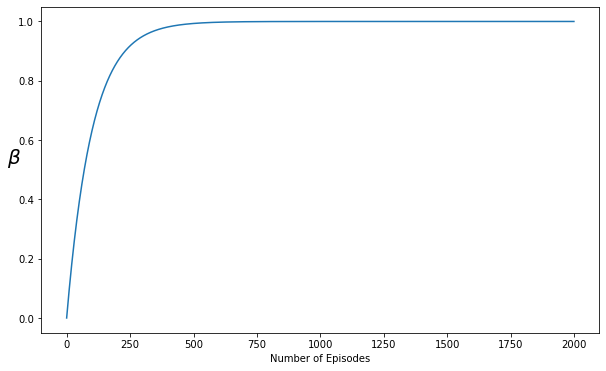

In [158]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10,6))
ns = np.arange(2000)
rate = 1e-2
_ = ax.plot(ns, exponential_annealing_schedule(ns, rate))
_ = ax.set_ylabel(r"$\beta$", rotation="horizontal", fontsize=20)
_ = ax.set_xlabel("Number of Episodes")

#### $\epsilon$-decay schedule

As was the case with the DQN and Double DQN algorithms, the agent chooses its action using an 
$\epsilon$-greedy policy. When using an $\epsilon$-greedy policy, with probability $\epsilon$, the 
agent explores the state space by choosing an action uniformly at random from the set of feasible 
actions; with probability $1-\epsilon$, the agent exploits its current knowledge by choosing the 
optimal action given that current state. 

As the agent learns and acquires additional knowledge about it environment it makes sense to 
*decrease* exploration and *increase* exploitation by decreasing $\epsilon$. In practice, it isn't 
a good idea to decrease $\epsilon$ to zero; instead one typically decreases $\epsilon$ over time 
according to some schedule until it reaches some minimum value.

In [73]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

#### Choosing an optimizer

Given the good results I achieved in my previous post from using the [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer I decided to continue to use that optimizer here.

In [74]:
from torch import optim


_optimizer_kwargs = {
    "lr": 1e-3,
    "betas":(0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

### Training the `DeepQAgent`

Now I am finally ready to train the `deep_q_agent`. The target score for the `LunarLander-v2` environment is 200 points on average for at least 100 consecutive episodes. If the `deep_q_agent` is able to "solve" the environment, then training will terminate early.

#### Uniform random sampling baseline

In [137]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "alpha": 0.0,
    "batch_size": 64,
    "buffer_size": 100000,
    "beta_annealing_schedule": lambda n: constant_annealing_schedule(n, 0.0),
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

uniform_sampling_scores = train(double_dqn_agent,
                                env,
                                "uniform-sampling-checkpoint.pth",
                                number_episodes=2000,
                                target_score=float("inf"))

Episode 100	Average Score: -113.36
Episode 200	Average Score: 51.15
Episode 300	Average Score: 119.37
Episode 400	Average Score: 158.45
Episode 500	Average Score: 154.08
Episode 600	Average Score: 216.22
Episode 700	Average Score: 220.47
Episode 800	Average Score: 229.12
Episode 900	Average Score: 223.13
Episode 1000	Average Score: 230.66
Episode 1100	Average Score: 229.96
Episode 1200	Average Score: 209.60
Episode 1300	Average Score: 190.09
Episode 1400	Average Score: 212.46
Episode 1500	Average Score: 219.84
Episode 1600	Average Score: 226.77
Episode 1700	Average Score: 231.39
Episode 1800	Average Score: 208.05
Episode 1900	Average Score: 183.24
Episode 2000	Average Score: 194.43


#### Prioritized sampling

In [139]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "alpha": 0.5,
    "batch_size": 64,
    "buffer_size": 100000,
    "beta_annealing_schedule": lambda n: exponential_annealing_schedule(n, 1e-2),
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

prioritized_sampling_scores = train(double_dqn_agent,
                                    env,
                                    "prioritized-sampling-checkpoint.pth",
                                    number_episodes=2000,
                                    target_score=float("inf"))

Episode 100	Average Score: -130.92
Episode 200	Average Score: 15.15
Episode 300	Average Score: 71.90
Episode 400	Average Score: 191.28
Episode 500	Average Score: 226.89
Episode 600	Average Score: 238.60
Episode 700	Average Score: 194.70
Episode 800	Average Score: 227.00
Episode 900	Average Score: 223.78
Episode 1000	Average Score: 228.35
Episode 1100	Average Score: 220.97
Episode 1200	Average Score: 220.92
Episode 1300	Average Score: 241.30
Episode 1400	Average Score: 209.41
Episode 1500	Average Score: 200.94
Episode 1600	Average Score: 202.66
Episode 1700	Average Score: 235.63
Episode 1800	Average Score: 249.41
Episode 1900	Average Score: 237.83
Episode 2000	Average Score: 259.26


#### Plotting the time series of scores

I can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Note that training stops as soon as the rolling average crosses the target score.

In [138]:
import pandas as pd

In [142]:
uniform_sampling_scores = pd.Series(uniform_sampling_scores, name="scores")
prioritized_sampling_scores = pd.Series(prioritized_sampling_scores, name="scores")

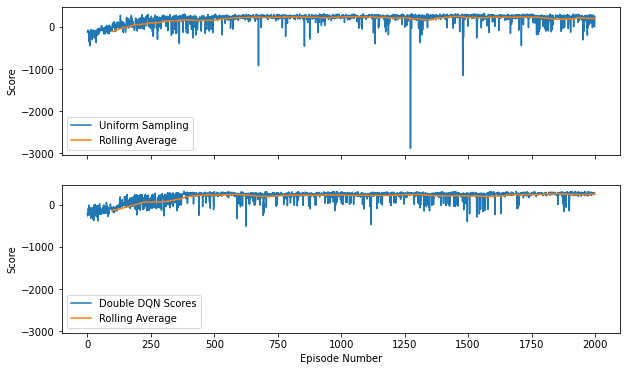

In [143]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = uniform_sampling_scores.plot(ax=axes[0], label="Uniform Sampling")
_ = (uniform_sampling_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
_ = axes[0].legend()
_ = axes[0].set_ylabel("Score")

_ = prioritized_sampling_scores.plot(ax=axes[1], label="Double DQN Scores")
_ = (prioritized_sampling_scores.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes[1]))
_ = axes[1].legend()
_ = axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")


#### Kernel density plot of the scores

In general, the kernel density plot will be bimodal with one mode less than -100 and a second mode greater than 200. The negative mode corresponds to those training episodes where the agent crash landed and thus scored at most -100; the positive mode corresponds to those training episodes where the agent "solved" the task. The kernel density or scores typically exhibits negative skewness (i.e., a fat left tail): there are lots of ways in which landing the lander can go horribly wrong (resulting in the agent getting a very low score) and only relatively few paths to a gentle landing (and a high score).

Depending, you may see that the distribution of scores for Double DQN has a significantly higher positive mode and lower negative mode when compared to the distribution for DQN which indicates that the agent trained with Double DQN solved the task *more* frequently and crashed and burned *less* frequently than the agent trained with DQN. 

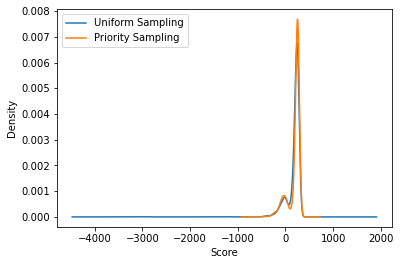

In [144]:
fig, ax = plt.subplots(1,1)
_ = uniform_sampling_scores.plot(kind="kde", ax=ax, label="Uniform Sampling")
_ = prioritized_sampling_scores.plot(kind="kde", ax=ax, label="Priority Sampling")
_ = ax.set_xlabel("Score")
_ = ax.legend()

## Where to go from here?

Up next in this series will be [*Dueling Network Architectures for Deep Reinforcement Learning*](https://arxiv.org/abs/1511.06581). 